<a href="https://colab.research.google.com/github/rohitnikam1/Econometrics/blob/master/13_The_Dangers_of_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is overfitting?**
When constructing a model, we tune both the parameters and the model by fitting to sample data. We then use the model and parameters to predict data we have not yet observed. We say a model is overfit when it is overly sensitive to noise and idiosyncracies in the sample data, and therefore does not reflect the underlying data-generating process.

To understand why this happens, one has to consider the amount of noise present in any dataset. One can consider a set of data as
, the true underlying data that came from whatever process we are trying to model, and , some random noise. Because what we see is $D = D_T + ϵ$, we might fit our model to very perfectly predict for the given $ϵ$, but not for $D$.



This is problematic because we only care about fitting to the sample insofar as that gives an accurate fit to future data. The two broad causes of overfitting are:

- small sample size, so that noise and trend are not distinguishable
- choosing an overly complex model, so that it ends up contorting to fit the noise in the sample


*If the model starts developing many specific rules based on specific past events, it is almost definitely overfitting. This is why black-box machine learning (neural networks, etc.) is so dangerous when not done correctly.*
--
## **Note: Model/Parameter Parsimony**
Just as the most elegant physics models describe a tremendous amount of our world through a few equations, a good trading model should explain most of the data through a few rules. Any time you start to have a number of rules even close to the number of points in your data set, you can be sure you are overfitting. Since parameters can be thought of as rules as they equivalently constrain a model, the same is true of parameters. Fewer parameters is better, and it is better to explain 60% of the data with 2-3 parameters than 90% with 10.
## **Beware of the perfect fit**
Because there is almost always noise present in real data, a perfect fit is almost always indicative of overfitting. It is almost impossible to know the percentage noise/signal in a given data set while you are developing the model, but use your common sense. Are the predictions surprisingly good? Then you're probably overfitting.
## **Example: Rolling windows**
One of the challenges in building a model that uses rolling parameter estimates, such as rolling mean or rolling beta, is choosing a window length. A longer window will take into account long-term trends and be less volatile, but it will also lag more when taking into account new observations. The choice of window length strongly affects the rolling parameter estimate and can change how we see and treat the data. Below we calculate the rolling averages of a stock price for different window lengths:


In [1]:
%%capture
!pip install yfinance  

In [2]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def get_data(tickers, start, end):
  '''Get stock data for tickers'''
  stockData = pdr.get_data_yahoo(tickers, start=start, end=end)
  stockData = stockData['Close']
  return stockData

[*********************100%***********************]  1 of 1 completed


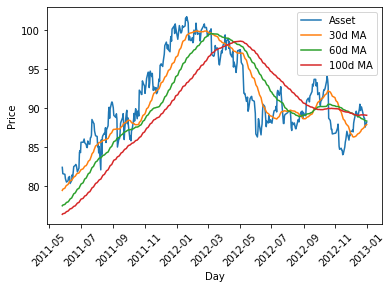

In [17]:
# Load the pricing data for a stock
start = '2011-01-01'
end = '2013-01-01'
pricing = get_data('MCD', start=start, end=end)

# Compute rolling averages for various window lengths
mu_30d = pricing.rolling(window=30).mean()
mu_60d = pricing.rolling(window=60).mean()
mu_100d = pricing.rolling(window=100).mean()

# Plot asset pricing data with rolling means from the 100th day, when all the means become available
plt.plot(pricing[100:], label='Asset')
plt.plot(mu_30d[100:], label='30d MA')
plt.plot(mu_60d[100:], label='60d MA')
plt.plot(mu_100d[100:], label='100d MA')
plt.tick_params(axis = 'x', rotation = 45)
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend();

If we pick the length which seems best - say, on how well our model or algorithm performs - we are overfitting. Below we have a simple trading algorithm which bets on the stock price reverting to the rolling mean. We use the performance of this algorithm to score window lengths and find the best one. However, when we consider a different timeframe, this window length is far from optimal. This is because our original choice was overfitted to the sample data.

In [18]:
# Trade using a simple mean-reversion strategy
def trade(stock, length):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0
    
    # Compute rolling mean and rolling standard deviation
    rolling_window = stock.rolling(window=length)
    mu = rolling_window.mean()
    std = rolling_window.std()
    
    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock - mu)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    count = 0
    for i in range(len(stock)):
        # Sell short if the z-score is > 1
        if zscores[i] > 1:
            money += stock[i]
            count -= 1
        # Buy long if the z-score is < 1
        elif zscores[i] < -1:
            money -= stock[i]
            count += 1
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            money += count*stock[i]
            count = 0
    return money

In [20]:
# Find the window length 0-254 that gives the highest returns using this strategy
length_scores = [trade(pricing, l) for l in range(255)]
best_length = np.argmax(length_scores)
print('Best window length:', best_length)

Best window length: 11


In [22]:
# Get pricing data for a different timeframe
start2 = '2013-01-01'
end2 = '2015-01-01'
pricing2 = get_data('MCD', start=start2, end=end2)

# Find the returns during this period using what we think is the best window length
length_scores2 = [trade(pricing2, l) for l in range(255)]
print(best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, and the returns using this window length
best_length2 = np.argmax(length_scores2)
print(best_length2, 'day window:', length_scores2[best_length2])

[*********************100%***********************]  1 of 1 completed
11 day window: 42.189918518066406
189 day window: 471.2797088623047


Clearly fitting to our sample data doesn't always give good results in the future. Just for fun, let's plot the length scores computed from the two different timeframes:

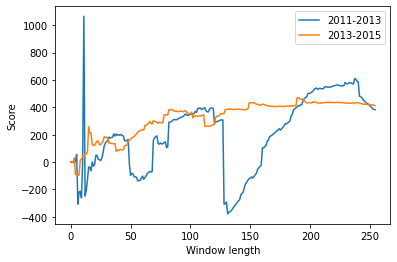

In [23]:
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['2011-2013', '2013-2015']);



To avoid overfitting, we can use economic reasoning or the nature of our algorithm to pick our window length. We can also use Kalman filters, which do not require us to specify a length; this method is covered in another notebook.
# **Avoiding overfitting**

We can try to avoid overfitting by taking large samples, choosing reasonable and simple models, and not cherry-picking parameters to fit the data; but just running two backtests is already overfitting.
## **Out of Sample Testing**

To make sure we haven't broken our model with overfitting, we have to out of sample. That is, we need to gather data that we did not use in constructing the model, and test whether our model continues to work. If we cannot gather large amounts of additional data at will, we should split the sample we have into two parts, of which one is reserved for testing only.
### **Common Mistake: Abusing Out of Sample Data**

Sometimes people will construct a model on in-sample data, test on out-of-sample data, and conclude it doesn't work. They will then repeat this process until they find a model that works. This is still overfitting, as you have no overfit the model to the out-of-sample data by using it many times, and when you actually test on true out-of-sample data your model will likely break down.
### **Cross Validation**

Cross validation is the process of splitting your data into n parts, then estimating optimal parameters for n-1 parts combined and testing on the final part. By doing this n times, one for each part held out, we can establish how stable our parameter estimates are and how predictive they are on data not from the original set.
## **Information Criterion**

Information criterion are a rigorous statistical way to test if the amount of complexity in your model is worth the extra predictive power. The test favors simpler models and will tell you if you are introducing a large amount of complexity without much return. One of the most common methods is Akaike Information Criterion.